## answers 03: _the adventure of the undead genes_

Our imports, to get started: we're using Pandas this week, and we're allowed NumPy, Matplotlib, and Seaborn too.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Moriarty's data

After having a look at the top, bottom, and a sample of Moriarty's file, I figure I can read it straight into a Pandas data frame with `pd.read_table()`. The file is tab-delimited, which is what `read_table()` expects by default. The file has some comment lines that start with `#`, so I'll use the `comment='#'` option to skip them. The first column is gene names, and I want to use those names as the index (row names) for my data frame, so I'll use the `index_col=0` option to make that so.

In [2]:
df_moriarty = pd.read_table('Moriarty_SuppTable1.tsv', comment='#', index_col=0)


I can check that this worked as I expected. The `.shape` property tells me an (nrows, ncolumns) tuple, the `.head()` method looks at the top, `.tail()` looks at the bottom, and `.sample()` gives me a random sample.

In [3]:
display(df_moriarty.shape)
display(df_moriarty.head(2))
display(df_moriarty.tail(2))
display(df_moriarty.sample(2))
# display(df_moriarty.info())      # uncomment to see geeky information about the dataframe

(4400, 12)

class    0m   3m   6m   9m  12m  15m  18m  21m  24m  27m  30m
gene                                                               
fcnZ  early   5.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
mnsN  early  12.0  5.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

class     0m   3m   6m   9m  12m  15m  18m  21m  24m  27m  30m
gene                                                                
wdkS  early   0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
nnaN  early  73.01  5.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

class      0m      3m      6m      9m     12m     15m     18m     21m  \
gene                                                                           
ufsH  middle  146.03  195.91  180.87  218.75  202.55  171.82  188.57  184.70   
obuP   early   33.01   29.99   21.98   21.97    8.98    9.99    7.98    7.99   

         24m    27m     30m  
gene                         
ufsH  156.91  138.9  126.07  
obuP    3.00    5.0    3.00

As discussed in class, I can check the values in each column if I'm paranoid. For numbers, it's useful to check their range. We're expecting TPMs to all be >= 0, for example, and they can't be > $10^6$ either. For categorical variables, it's useful to check the set of values that's present. For example, checking the range of TPMs in the `0m` column:

In [4]:
df_moriarty['0m'].sort_values()

gene
hepQ        0.00
krrV        0.00
omfV        0.00
cqfJ        0.00
bpfG        0.00
          ...   
xnpF    10455.87
atxT    13045.34
grzT    16991.04
eytU    21064.77
mkqZ    23491.20
Name: 0m, Length: 4400, dtype: float64

... or checking the set of values in the `class` column, to make sure that it only contains the expected "early", "middle", "late":

In [5]:
set(df_moriarty['class'])

{'early', 'late', 'middle'}

... or sorting the gene names in the index, knowing that weird non-strings will sort to the extremes:

In [6]:
df_moriarty.index.sort_values()

Index(['1-Dec', '1-Mar', '1-Oct', '1-Sep', '2-Mar', '2-Oct', '2-Sep',  'aacU',
        'aalG',  'aavD',
       ...
        'zykS',  'zypC',  'zzeJ',  'zziF',  'zzmY',  'zztB',  'zzuJ',  'zzxG',
        'zzyT',     nan],
      dtype='object', name='gene', length=4400)

OK, this looks not so good, actually. Better have a closer look.

### Some problems in Moriarty's gene names

At the top of that sorted list, I have seven "gene names" that look like dates "1-Dec", etc., instead of gene names. Let's leave them for now, until we see the gene names that the Adler file uses. Maybe they're real gene names somehow? We'll defer judgement. (They won't turn out to be real; they won't match Adler's names.)

I'm more immediately worried about the *last* item in the sorted list. It's not even a string, if you look closely: it says `nan` with no quotes, not `"nan"`.

Let's find what row number that gene is on, with an eye toward fixing its name in the index. Normally, to look up something by name in the index (or a column, or any 1D Pandas `Series` object), I can use the `.get_loc()` method, or alternatively, I can always convert a Pandas`Series` to a plain Python list and find the element in the list with the list's `.index()` method. (Not to be confused with the Pandas data frame index.) For example:

In [7]:
df_moriarty.index.get_loc('hkaH')          # find the row number that gene "hkaH" is on

4394

In [8]:
list(df_moriarty.index).index('hkaH')      # find the row number that gene "hkaH" is on, another way to do it

4394

In [9]:
df_moriarty.iloc[4394]      # pull row 4394 out of the data frame

class    middle
0m          4.0
3m          1.0
6m          5.0
9m          1.0
12m         0.0
15m         4.0
18m         2.0
21m         0.0
24m         0.0
27m         0.0
30m         0.0
Name: hkaH, dtype: object

But for this `nan` in Moriarty's gene names, that doesn't work! If you try, Python barfs. The reason that Python barfs is that `NaN` (case insensitive) is "not a number": a special numerical value indicating an unrepresentable floating point value. NaN is never equal to anything, including itself, so `NaN == NaN` tests return FALSE. tests like `gene == NaN`, they'll always fail, and in many circumstances, Python will consider NaN to be invalid input. Having a `NaN` in the DataFrame's index is a little insidious.

How did this "nan" get there? Let's check the original file:

In [10]:
! grep nan Moriarty_SuppTable1.tsv

nan	early	12.00	3.00	3.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00


Oh. Because there's actually a gene named "nan". Sigh.

Pandas tries to automatically detect when strings look like numbers. It did that for all our TPM's, for example, and we appreciate that. It didn't leave them as text strings, it quietly and correctly converted them to floats. But here, it took a gene named "nan" and interpreted that as the `NaN` special value. That was too aggressive, Pandas. 

Seeing Pandas do this is a reminder that it's doing this autoconversion of our input fields, and you need to watch out for it getting things wrong occasionally.

You know how I first encountered this in Pandas? There really is [a _Drosophila_ gene named "nan"](https://www.alliancegenome.org/gene/FB:FBgn0036414). Pandas corrupted one of my data tables for a Drosophila RNA-seq experiment.

How to fix it? I have two options. One is that I can re-read the data file with an option telling Pandas "don't do that". Read the Pandas documentation, and you find the option `na_filter=False`, which turns off Pandas conversion of values to NaN:

In [11]:
df = pd.read_table('Moriarty_SuppTable1.tsv', comment='#', index_col=0, na_filter=False)
df.index.sort_values()

Index(['1-Dec', '1-Mar', '1-Oct', '1-Sep', '2-Mar', '2-Oct', '2-Sep', 'aacU',
       'aalG', 'aavD',
       ...
       'zyiT', 'zykS', 'zypC', 'zzeJ', 'zziF', 'zzmY', 'zztB', 'zzuJ', 'zzxG',
       'zzyT'],
      dtype='object', name='gene', length=4400)

Another option is to directly edit the index. That's what I'll do in the `df_moriarty` data frame that I'm keeping. First I find the position of the bad gene name, using `pd.isnull()` to test for the NaN value (since `v == float('NaN')` won't work!):

In [12]:
for i,v in enumerate(df_moriarty.index):
    if pd.isnull(v): print(i)

2532


and then I change that gene name. There isn't a super direct way to do this, because the Pandas index isn't "mutable". I have to convert the index to a list, change the element I want to edit, then reload the list back into the data frame's index.

In [13]:
L = list(df_moriarty.index)
if pd.isnull(L[2532]): L[2532] = 'nan'    # the string 'nan', dammit
df_moriarty.index = L    

In [14]:
df_moriarty.index.sort_values()

Index(['1-Dec', '1-Mar', '1-Oct', '1-Sep', '2-Mar', '2-Oct', '2-Sep', 'aacU',
       'aalG', 'aavD',
       ...
       'zyiT', 'zykS', 'zypC', 'zzeJ', 'zziF', 'zzmY', 'zztB', 'zzuJ', 'zzxG',
       'zzyT'],
      dtype='object', length=4400)

OK. Still have those date-like names to worry about, but let's proceed to Adler's data.

## Adler's data

Now that we know there's a gene named "nan", we'll read the Adler data in accordingly:

In [15]:
df_adler = pd.read_table('Adler_SuppTable2.tsv', comment='#', index_col=0, na_filter=False)
df_adler.head(3)

synthesis_rate  halflife
gene                          
lsuW            0.27      1.85
ilaK            0.01      0.47
rmwC            0.58     14.76

I'll leave out the various checking of Adler's data. I would do the same things as I did with Moriarty's, or any new data table I'm going to manipulate for my work.

## 1. Check that the gene names match

Are Moriarty and Adler working with the same 4400 gene names? 

One easy way is with set operations. Using sets, it's also easy to check that the 4400 names are unique.

In [16]:
moriarty_names = set(df_moriarty.index)
adler_names    = set(df_adler.index)
print("Moriarty has: {} names".format(len(moriarty_names)))
print("Adler has: {} names".format(len(adler_names)))

Moriarty has: 4400 names
Adler has: 4400 names


and it's easy to use a set difference to see elements in the `moriarty_names` set that aren't in the `adler_names` set, and vice versa:

In [17]:
print(moriarty_names - adler_names)
print(adler_names    - moriarty_names)

{'1-Sep', '2-Mar', '1-Dec', '1-Oct', '1-Mar', '2-Sep', '2-Oct'}
{'mar2', 'dec1', 'oct2', 'oct1', 'sep2', 'sep1', 'mar1'}


Moriarty's names have been corrupted by Excel into date formats. 

Of course, I telegraphed this problem to you when I wrote the pset and cited a couple of papers on a common Excel data corruption in genomics. Like Pandas, Excel attempts to autodetect the format of input fields, and its default is even more aggressive than Pandas. Anything that looks like a date will be converted to a date format. There are a lot of gene names that look like dates. A few examples from the human genome are SEPT1, OCT1, and MARCH1. 

Let's fix these. I'll be a little general and systematic about it, by making a dict for all the conversions I want to do.

In [18]:
edits = { '1-Oct' : 'oct1',
          '2-Oct' : 'oct2',
          '1-Mar' : 'mar1',
          '2-Mar' : 'mar2',
          '1-Sep' : 'sep1',
          '2-Sep' : 'sep2',
          '1-Dec' : 'dec1' }

L = list(df_moriarty.index)               # We can't edit the (immutable) index directly. Pull it out as a list...
for i, elem in enumerate(L):              #   ... walk through it one element at a time ...
    if elem in edits: L[i] = edits[elem]  #   ... fix the names we want to fix ...
df_moriarty.index = L                     #   ... and re-install this fixed list as our index

moriarty_names = set(df_moriarty.index)   # check that we did it right
print(adler_names - moriarty_names)
print(moriarty_names - adler_names)
df_moriarty.index.sort_values()

set()
set()


Index(['aacU', 'aalG', 'aavD', 'aayZ', 'aazN', 'abfW', 'abhA', 'abnM', 'abnN',
       'abpY',
       ...
       'zyiT', 'zykS', 'zypC', 'zzeJ', 'zziF', 'zzmY', 'zztB', 'zzuJ', 'zzxG',
       'zzyT'],
      dtype='object', length=4400)

Now our two data frames share the same 4400 names.

## 2. tidy the data

We already did the most important tidying above. Here, we just mean, convert the wide Moriarty table to the more-tidy long form, by learning how to use the Pandas `melt()` method.

In [19]:
df_moriarty.head(2)

class    0m   3m   6m   9m  12m  15m  18m  21m  24m  27m  30m
fcnZ  early   5.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
mnsN  early  12.0  5.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Moriarty's data is in "wide" format. If we want to have it in "long" format, we `melt()` the 11 columns `0m`..`30m` into two new columns that we'll call `time` and `tpm`. 

Pandas `.melt()` will create a new DataFrame that loses your original index, by default. I'm setting the `ignore_index=False` option so it keeps my gene names index.

The `id_vars=[]` option is a list of columns you want to keep in the new table, without melting. Here I want to keep Moriarty's `class` column, and melt the rest to two new columns that I name with `var_name='time', value_name='tpm'`: all the old column names melt down to the new `var_name` column, and all the old values in those columns melt to the new `value_name` column.

We'll also want to treat `time` as an integer variable, so we'll need to edit that new column to get rid of the `m`'s. You may need to carefully unpack what my code is doing here. I can replace any DataFrame column to a list with the same number of rows just by saying `df['colname'] = L`. So I'm using a list comprehension, of syntax `[ x for x in L ]`, to make that new list by walking through another list, which is the original `dfm['time']` column. For each string value `s` in the original column, I strip the trailing `m` off of it with `s.rstrip('m')`, then convert what's left to an integer with `int()`.

In [20]:
dfm_long = pd.melt(df_moriarty, ignore_index=False, id_vars=['class'], var_name='time', value_name='tpm')
dfm_long['time'] = [ int(s.rstrip('m')) for s in dfm_long['time'] ]     # here I'm replacing the whole column with a new list.
dfm_long.head(5)

class  time    tpm
fcnZ   early     0   5.00
mnsN   early     0  12.00
eqoN  middle     0  65.01
gupU   early     0  65.01
wccP   early     0  68.01

Nice to know, but I'm really not going to end up using this - the wide form table ends up being more useful in this case.

## 3. explore the data

We've already done some exploration for the purposes of validating that the data tables are ok. Now we're doing it for the purpose of figuring out what Moriarty's artifact might be. Why does it look like some host genes are increasing in expression level even after RNA synthesis is blocked and the host is dead?

Of course this is an exercise in sorting and subsetting Pandas DataFrames. The workhorse sorting method for a 2D Pandas DataFrame or a 1D Pandas Series is `.sort_values()`.

### ... _output the five genes with highest mRNA synthesis rates, in Adler data_

In [21]:
df_adler.sort_values(by='synthesis_rate', ascending=False).head(5)     # note how I can chain methods together compactly.
                                                                       # (df.sort_values()) returns a DataFrame; 
                                                                       # I can immediately call .head() on that return value.

synthesis_rate  halflife
gene                          
uzdZ           15.96      2.45
mkqZ           15.39      8.91
pfhT           14.67      1.48
coxU           13.28      1.74
wduX           12.02      2.65

### ... _output the five genes with the longest mRNA halflife, in Adler data_

In [22]:
df_adler.sort_values(by='halflife', ascending=False).head(5)

synthesis_rate  halflife
gene                          
qonD            0.16    114.98
cxyH            0.15     63.57
znkB            0.07     57.79
qyfB            0.14     52.48
qunV            0.33     42.06

A suspicious thing here: qonD and cxyH, at the top of the list for the most stable host mRNAs, are the two examples of "late" genes in the figure in the pset. 

### ...output the five genes with the highest expression ratio 30'/0', in Moriarty data

A little more tricky, because we're sorting on a function of data values, not just on the values in a column.

And we also quickly find that we have zeros in both 0m and 30m columns, so we get ratios of 0/0 = NaN and x/0 = infinity that we need to figure out what to do with, to have the sort make sense. 

Since these 0/0 and x/0 cases only arise when the gene is lowly-expressed to begin with (0 TPM at 0'), and lowly-expressed genes are the most noisy, it's probably reasonable to just ignore these genes. So to make sure they don't sort to the extremes, I'll assign them a sortkey of 1.0. I can globally replace values in a table with `.replace(np.inf, 1)`, for example.

In [23]:
df_moriarty['sortkey'] = df_moriarty['30m'] / df_moriarty['0m']
df_moriarty            = df_moriarty.replace(np.inf, 1)
df_moriarty            = df_moriarty.replace(np.nan, 1)
display(df_moriarty.sort_values(by='sortkey', ascending=False).head(5))

class       0m       3m       6m       9m      12m       15m       18m  \
qonD  late  3144.56  4446.87  6107.52  7636.21  9492.80  11710.03  14004.43   
znkB  late   606.11   946.55  1290.05  1547.22  1869.82   2325.62   2763.77   
cxyH  late  1609.29  2367.86  3135.70  3913.50  4912.03   5933.94   6774.73   
qyfB  late  1263.23  1794.14  2290.32  2843.73  3649.85   4227.68   4881.00   
nwoU  late    37.01    35.98    60.96    80.91   102.77    107.89    120.73   

           21m       24m       27m       30m   sortkey  
qonD  16428.71  19183.53  22259.64  25158.11  8.000518  
znkB   2982.23   3506.90   3953.09   4609.59  7.605204  
cxyH   7895.37   9271.46  10397.36  11722.58  7.284318  
qyfB   5684.90   6371.19   7297.64   8352.69  6.612169  
nwoU    124.80    169.90    196.86    243.14  6.569576

Lemme just repeat the list of top five most stable mRNAs from the Adler data, above:

In [24]:
df_adler.sort_values(by='halflife', ascending=False).head(5)

synthesis_rate  halflife
gene                          
qonD            0.16    114.98
cxyH            0.15     63.57
znkB            0.07     57.79
qyfB            0.14     52.48
qunV            0.33     42.06

A lot of overlap in those lists. Moriarty's strongest "late" genes correspond to the most stable mRNAs. A big clue.

I'll delete the 'sortkey' column now, so I have the original table again.

In [25]:
df_moriarty = df_moriarty.drop(columns='sortkey')
df_moriarty.head(2)

class    0m   3m   6m   9m  12m  15m  18m  21m  24m  27m  30m
fcnZ  early   5.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
mnsN  early  12.0  5.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

## 4. merge the data

This is another exercise in manipulating Pandas data frames: knowing how to merge them with the `.concat()` or `.merge()` methods. The pset instructions offered a couple of ways of doing this. 

From the stuff above, I already suspect a correlation between Moriarty's "late" genes and halflife, so I imagine wanting to do a plot that shows that correlation, using that t30'/t0' statistic as a measure of the strength of the increased expression level. That will probably be most revealing, but I also probably want to look at the "middle" genes. I'll invent a statistic that'll help me define the strength of "middle" genes: the maximum expression value in the middle time points 3'-27', over the maximum expression value at the endpoints 0',30'.

I'll concat the Moriarty (wide) and Adler tables together, then add these two statistics as new columns.

In [26]:
dfm = pd.concat([df_moriarty, df_adler], axis=1)  # merge Moriarty and Adler's data. axis=1 means a horizontal merge.

dfm['30m/0m']      = df_moriarty['30m'] / df_moriarty['0m']
dfm['max_mid/end'] = df_moriarty.loc[:,['0m','30m']].max(axis=1) / df_moriarty.loc[:,'3m':'27m'].max(axis=1)
dfm.replace(np.inf, 1, inplace=True)              # Using my same hack of basically ignoring 0/0 NaN and x/0 inf values in my new columns.
dfm.replace(np.nan, 1, inplace=True)
dfm.loc[ dfm['class'] == 'late' ].sort_values(by='30m/0m', ascending=False)


class       0m       3m       6m       9m      12m       15m       18m  \
qonD  late  3144.56  4446.87  6107.52  7636.21  9492.80  11710.03  14004.43   
znkB  late   606.11   946.55  1290.05  1547.22  1869.82   2325.62   2763.77   
cxyH  late  1609.29  2367.86  3135.70  3913.50  4912.03   5933.94   6774.73   
qyfB  late  1263.23  1794.14  2290.32  2843.73  3649.85   4227.68   4881.00   
nwoU  late    37.01    35.98    60.96    80.91   102.77    107.89    120.73   
...    ...      ...      ...      ...      ...      ...       ...       ...   
oemW  late   370.07   483.77   557.59   564.35   573.72    612.37    636.57   
bgxW  late    65.01    75.96    79.94    77.91    81.82    101.90     85.81   
hndD  late    19.00    14.99    16.99    19.98    13.97     24.97     26.94   
ghfI  late    25.00    18.99    30.98    25.97    24.94     31.97     28.93   
wpzK  late     2.00     0.00     0.00     0.00     2.00      0.00      1.00   

           21m       24m       27m       30m  synthesis_rate  halflife  \
qonD  16428.71  19183.53  22259.64  25158.11            0.16    114.98   
znkB   2982.23   3506.90   3953.09   4609.59            0.07     57.79   
cxyH   7895.37   9271.46  10397.36  11722.58            0.15     63.57   
qyfB   5684.90   6371.19   7297.64   8352.69            0.14     52.48   
nwoU    124.80    169.90    196.86    243.14            0.01     41.34   
...        ...       ...       ...       ...             ...       ...   
oemW    618.01    622.63    625.54    641.36            0.20     11.10   
bgxW     86.86     94.94    102.92    109.06            0.03     11.22   
hndD     29.95     27.98     27.98     30.02            0.00     15.91   
ghfI     23.96     31.98     31.98     33.02            0.01     11.14   
wpzK      0.00      0.00      1.00      2.00            0.00      4.37   

        30m/0m  max_mid/end  
qonD  8.000518     1.130212  
znkB  7.605204     1.166073  
cxyH  7.284318     1.127457  
qyfB  6.612169     1.144574  
nwoU  6.569576     1.235091  
...        ...          ...  
oemW  1.733078     1.007525  
bgxW  1.677588     1.059658  
hndD  1.580000     1.002337  
ghfI  1.320800     1.032520  
wpzK  1.000000     1.000000  

[157 rows x 16 columns]

## 5. figure out the explanation

Now I can explore my merged joint data table in various ways. A particularly telling one is to sort it by halflife or by the 30m/0m statistic. We can see there's a strong correlation even without needing a plot.

In [27]:
dfm.loc[ dfm['class'] == 'late' ].sort_values(by='30m/0m', ascending=False)

class       0m       3m       6m       9m      12m       15m       18m  \
qonD  late  3144.56  4446.87  6107.52  7636.21  9492.80  11710.03  14004.43   
znkB  late   606.11   946.55  1290.05  1547.22  1869.82   2325.62   2763.77   
cxyH  late  1609.29  2367.86  3135.70  3913.50  4912.03   5933.94   6774.73   
qyfB  late  1263.23  1794.14  2290.32  2843.73  3649.85   4227.68   4881.00   
nwoU  late    37.01    35.98    60.96    80.91   102.77    107.89    120.73   
...    ...      ...      ...      ...      ...      ...       ...       ...   
oemW  late   370.07   483.77   557.59   564.35   573.72    612.37    636.57   
bgxW  late    65.01    75.96    79.94    77.91    81.82    101.90     85.81   
hndD  late    19.00    14.99    16.99    19.98    13.97     24.97     26.94   
ghfI  late    25.00    18.99    30.98    25.97    24.94     31.97     28.93   
wpzK  late     2.00     0.00     0.00     0.00     2.00      0.00      1.00   

           21m       24m       27m       30m  synthesis_rate  halflife  \
qonD  16428.71  19183.53  22259.64  25158.11            0.16    114.98   
znkB   2982.23   3506.90   3953.09   4609.59            0.07     57.79   
cxyH   7895.37   9271.46  10397.36  11722.58            0.15     63.57   
qyfB   5684.90   6371.19   7297.64   8352.69            0.14     52.48   
nwoU    124.80    169.90    196.86    243.14            0.01     41.34   
...        ...       ...       ...       ...             ...       ...   
oemW    618.01    622.63    625.54    641.36            0.20     11.10   
bgxW     86.86     94.94    102.92    109.06            0.03     11.22   
hndD     29.95     27.98     27.98     30.02            0.00     15.91   
ghfI     23.96     31.98     31.98     33.02            0.01     11.14   
wpzK      0.00      0.00      1.00      2.00            0.00      4.37   

        30m/0m  max_mid/end  
qonD  8.000518     1.130212  
znkB  7.605204     1.166073  
cxyH  7.284318     1.127457  
qyfB  6.612169     1.144574  
nwoU  6.569576     1.235091  
...        ...          ...  
oemW  1.733078     1.007525  
bgxW  1.677588     1.059658  
hndD  1.580000     1.002337  
ghfI  1.320800     1.032520  
wpzK  1.000000     1.000000  

[157 rows x 16 columns]

Another way to look at that is to plot the halflives of Moriarty's early, middle, and late genes. I like using strip plots, so I see each data point.

<Axes: xlabel='class', ylabel='halflife'>

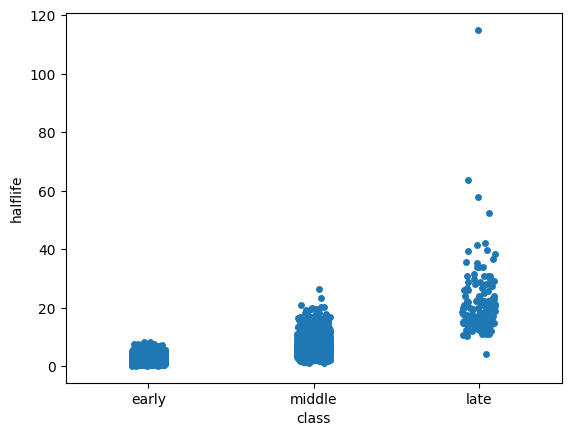

In [28]:
fig, ax = plt.subplots()
sns.stripplot(ax=ax, data=dfm, x='class', y='halflife')

I feel like I went to all the trouble of doing the `melt()` to make a long-form table `dfm_long` of Moriarty's data, I ought to show something it's useful for. Here's an example: it's how I made the plots for the figure in the pset instructions.

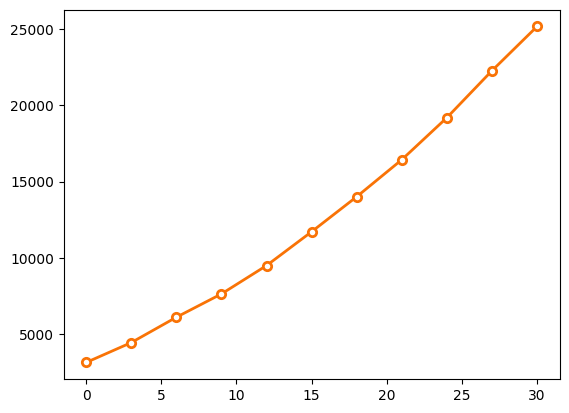

In [29]:
gene = 'qonD'
fig, ax = plt.subplots()
ax.plot(dfm_long.loc[gene,'time'],
        dfm_long.loc[gene,'tpm'],
        marker='o',
        markerfacecolor='w', 
        markeredgecolor=('xkcd:orange'),
        markeredgewidth=2,
        color=('xkcd:orange'), 
        linewidth=2)


### so what happened is...

The key idea is that RNA-seq experiments measure _relative_ RNA abundance, not _absolute_. TPM units mean "transcripts per million transcripts". 

When Moriarty inhibited new RNA synthesis, all the mRNAs started decaying on exponential curves according to their different halflives. The least stable ones decay fastest and disappear, leaving the more stable ones. In absolute terms, all the mRNAs are going away; but because the more stable ones are persisting longer, they become a larger and larger fraction of the surviving mRNA at longer time points, and their TPMs rise.

Counterintuitively, this same effect can result in genes with moderate half-lives appearing to rise then fall - Moriarty's "middle" genes. They rise in relative abundance as the fast-decaying mRNAs decay, and then fall as they decay to leave only the slow-decaying ones.

If Moriarty had done any sort of experiment to measure absolute RNA abundance - like, measuring the yield of his RNA prep per input cell - he might've been able to see this artifact better. It's possible to do RNA-seq experiments where you use spike-in RNA controls of known amounts, plus counting your input cell number, to be able to convert relative TPM abundances to an inference of actual mRNA number per cell. 

In [30]:
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyter

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

numpy     : 2.1.0
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyter   : 1.0.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

